# Question 2.1: RNA Binding Protein Affinity Prediction

This notebook implements two deep learning architectures:
1. **CNN**: Convolutional Neural Network for motif detection
2. **LSTM**: Bidirectional LSTM for sequence modeling

## Setup and Imports


In [1]:
# Install dependencies (if needed)
# !pip install openpyxl

import os
import sys
import json
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List, Tuple

# Add Kaggle input directory to path (if files are in a dataset)
# This handles the case where files are in /kaggle/input/dataset_name/
if os.path.exists('/kaggle/input'):
    # Find the dataset directory (usually named like 'normdata' or similar)
    input_dirs = [d for d in os.listdir('/kaggle/input') if os.path.isdir(os.path.join('/kaggle/input', d))]
    if input_dirs:
        dataset_path = os.path.join('/kaggle/input', input_dirs[0])
        sys.path.insert(0, dataset_path)
        print(f"Added dataset path to sys.path: {dataset_path}")
    else:
        # If files are directly in /kaggle/input, add that
        sys.path.insert(0, '/kaggle/input')
        print("Added /kaggle/input to sys.path")

# Also add working directory (for files uploaded directly to notebook)
sys.path.insert(0, '/kaggle/working')
sys.path.insert(0, os.getcwd())

# Import from local files
from utils import (
    load_rnacompete_data,
    masked_mse_loss,
    masked_spearman_correlation,
    configure_seed,
    plot
)
from hw2_q2_models import create_model

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set seed for reproducibility
configure_seed(42)


Added dataset path to sys.path: /kaggle/input/normdata
Using device: cuda


## Configuration

Set your hyperparameters here:


In [2]:
# Update config paths for Kaggle (if data is in input directory)
from config import RNAConfig

# Check if we're in Kaggle and data is in input directory
if os.path.exists('/kaggle/input'):
    input_dirs = [d for d in os.listdir('/kaggle/input') if os.path.isdir(os.path.join('/kaggle/input', d))]
    if input_dirs:
        dataset_path = os.path.join('/kaggle/input', input_dirs[0])
        # Update config to use absolute paths
        config = RNAConfig(
            DATA_PATH=os.path.join(dataset_path, 'norm_data.txt'),
            METADATA_PATH=os.path.join(dataset_path, 'metadata.xlsx')
        )
        print(f"Updated config paths to use dataset: {dataset_path}")
    else:
        config = RNAConfig()
else:
    config = RNAConfig()

# Global configuration
PROTEIN = 'RBFOX1'  # Must be RBFOX1 for this assignment
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 100
PATIENCE = 10  # Early stopping patience

# CNN hyperparameters
CNN_CONFIG = {
    'num_filters': 64,
    'filter_sizes': [3, 5, 7],
    'dropout_rate': 0.2,
    'hidden_units': 128,
    'num_dense_layers': 2
}

# LSTM hyperparameters
LSTM_CONFIG = {
    'lstm_hidden_size': 128,
    'num_lstm_layers': 2,
    'dropout_rate': 0.2,
    'dense_units': 128,
    'aggregation': 'last',  # 'last', 'attention', or 'mean'
    'use_embedding': False
}

print("Configuration set!")


Updated config paths to use dataset: /kaggle/input/normdata
Configuration set!


## Load Data


In [3]:
print("Loading data...")
train_dataset = load_rnacompete_data(PROTEIN, split='train', config=config)
val_dataset = load_rnacompete_data(PROTEIN, split='val', config=config)
test_dataset = load_rnacompete_data(PROTEIN, split='test', config=config)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Loading data...
Loading Metadata from /kaggle/input/normdata/metadata.xlsx...


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  > Metadata loaded in 0.64 seconds.
Loading Data from /kaggle/input/normdata/norm_data.txt...
  > Data Matrix loaded in 50.38 seconds.
Saving processed data to data/RBFOX1_train_data.pt...
Loading Metadata from /kaggle/input/normdata/metadata.xlsx...
  > Metadata loaded in 0.05 seconds.
Loading Data from /kaggle/input/normdata/norm_data.txt...


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  > Data Matrix loaded in 45.28 seconds.
Saving processed data to data/RBFOX1_val_data.pt...
Loading Metadata from /kaggle/input/normdata/metadata.xlsx...
  > Metadata loaded in 0.05 seconds.
Loading Data from /kaggle/input/normdata/norm_data.txt...


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


  > Data Matrix loaded in 44.99 seconds.
Saving processed data to data/RBFOX1_test_data.pt...
Train samples: 96261
Validation samples: 24065
Test samples: 121031


## Hyperparameter Tuning

**IMPORTANT**: This section tunes hyperparameters using the **validation set**. The test set is only used once at the very end for final evaluation.

**Choose one:**
- **Option A**: Run hyperparameter tuning (recommended) - Use the cells below
- **Option B**: Skip tuning and use default hyperparameters - Comment out the tuning cells and use the default configs from Cell 3


In [ ]:
# ============================================================================
# HYPERPARAMETER TUNING SETUP
# ============================================================================
# This cell defines the hyperparameter search space and tuning function
# You can modify the search spaces below to explore different hyperparameters

import random
from copy import deepcopy

# Define hyperparameter search spaces
CNN_SEARCH_SPACE = {
    'num_filters': [32, 64, 128],
    'filter_sizes': [[3, 5], [3, 5, 7], [5, 7]],
    'dropout_rate': [0.0, 0.2, 0.4],
    'hidden_units': [64, 128, 256],
    'num_dense_layers': [1, 2, 3],
    'learning_rate': [1e-4, 5e-4, 1e-3, 5e-3]
}

LSTM_SEARCH_SPACE = {
    'lstm_hidden_size': [64, 128, 256],
    'num_lstm_layers': [1, 2],
    'dropout_rate': [0.0, 0.2, 0.4],
    'dense_units': [64, 128, 256],
    'aggregation': ['last', 'mean'],
    'use_embedding': [False, True],
    'learning_rate': [1e-4, 5e-4, 1e-3, 5e-3]
}

def sample_random_config(search_space):
    """Sample a random hyperparameter configuration from search space."""
    config = {}
    for key, values in search_space.items():
        config[key] = random.choice(values)
    return config

def train_and_evaluate_config(model_type, config, train_loader, val_loader, device, 
                              num_epochs=100, patience=10, verbose=False):
    """
    Train a model with given hyperparameters and return validation performance.
    
    Args:
        model_type: 'cnn' or 'lstm'
        config: Dictionary of hyperparameters
        train_loader: Training data loader
        val_loader: Validation data loader (used for tuning!)
        device: torch device
        num_epochs: Maximum number of epochs
        patience: Early stopping patience
        verbose: Whether to print training progress
    
    Returns:
        Dictionary with validation performance metrics
    """
    # Extract learning rate (needed for optimizer)
    learning_rate = config.pop('learning_rate', LEARNING_RATE)
    
    # Create model
    model = create_model(model_type, **config)
    model = model.to(device)
    
    # Create optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Train model (uses validation set for early stopping)
    history = train_model(model, train_loader, val_loader, optimizer, 
                         num_epochs, device, patience)
    
    # Return validation performance
    return {
        'config': config,
        'learning_rate': learning_rate,
        'best_val_correlation': history['best_val_correlation'],
        'final_val_loss': history['val_losses'][-1],
        'num_epochs_trained': len(history['train_losses']),
        'model_state': model.state_dict()  # Save best model state
    }

print("✓ Hyperparameter tuning functions defined!")
print("\nSearch spaces:")
print(f"  CNN: {len(CNN_SEARCH_SPACE)} hyperparameters")
print(f"  LSTM: {len(LSTM_SEARCH_SPACE)} hyperparameters")
print("\nReady for hyperparameter tuning!")


### Tune CNN Hyperparameters

**Strategy**: Random search - Try N random combinations and pick the best based on validation performance.


In [ ]:
# ============================================================================
# CNN HYPERPARAMETER TUNING
# ============================================================================
# This will try multiple CNN configurations and select the best one
# based on VALIDATION set performance (NOT test set!)

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Number of random configurations to try
NUM_CNN_TRIALS = 10  # Increase this for more thorough search (but slower)

print("="*80)
print("CNN HYPERPARAMETER TUNING")
print("="*80)
print(f"Trying {NUM_CNN_TRIALS} random configurations...")
print("Using VALIDATION set for tuning (NOT test set!)\n")

cnn_tuning_results = []

for trial in range(NUM_CNN_TRIALS):
    print(f"\n{'='*80}")
    print(f"Trial {trial + 1}/{NUM_CNN_TRIALS}")
    print(f"{'='*80}")
    
    # Sample random configuration
    config = sample_random_config(CNN_SEARCH_SPACE)
    config['learning_rate'] = random.choice(CNN_SEARCH_SPACE['learning_rate'])
    
    print(f"Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    # Train and evaluate on VALIDATION set
    result = train_and_evaluate_config(
        'cnn', 
        deepcopy(config),  # Deep copy to avoid modifying original
        train_loader, 
        val_loader,  # ← Using VALIDATION set for tuning!
        device,
        num_epochs=NUM_EPOCHS,
        patience=PATIENCE,
        verbose=True
    )
    
    cnn_tuning_results.append(result)
    print(f"\n✓ Trial {trial + 1} complete")
    print(f"  Best validation correlation: {result['best_val_correlation']:.4f}")

# Find best configuration
best_cnn_result = max(cnn_tuning_results, key=lambda x: x['best_val_correlation'])

print("\n" + "="*80)
print("CNN TUNING SUMMARY")
print("="*80)
print(f"Best validation correlation: {best_cnn_result['best_val_correlation']:.4f}")
print(f"\nBest CNN configuration:")
for key, value in best_cnn_result['config'].items():
    print(f"  {key}: {value}")
print(f"  learning_rate: {best_cnn_result['learning_rate']}")

# Update CNN_CONFIG with best hyperparameters
CNN_CONFIG = best_cnn_result['config'].copy()
CNN_CONFIG['learning_rate'] = best_cnn_result['learning_rate']
LEARNING_RATE_CNN = best_cnn_result['learning_rate']

print("\n✓ Best CNN configuration saved to CNN_CONFIG")
print("="*80)


### Tune LSTM Hyperparameters

**Strategy**: Random search - Try N random combinations and pick the best based on validation performance.


In [ ]:
# ============================================================================
# LSTM HYPERPARAMETER TUNING
# ============================================================================
# This will try multiple LSTM configurations and select the best one
# based on VALIDATION set performance (NOT test set!)

# Set random seed for reproducibility
random.seed(42)
torch.manual_seed(42)

# Number of random configurations to try
NUM_LSTM_TRIALS = 10  # Increase this for more thorough search (but slower)

print("="*80)
print("LSTM HYPERPARAMETER TUNING")
print("="*80)
print(f"Trying {NUM_LSTM_TRIALS} random configurations...")
print("Using VALIDATION set for tuning (NOT test set!)\n")

lstm_tuning_results = []

for trial in range(NUM_LSTM_TRIALS):
    print(f"\n{'='*80}")
    print(f"Trial {trial + 1}/{NUM_LSTM_TRIALS}")
    print(f"{'='*80}")
    
    # Sample random configuration
    config = sample_random_config(LSTM_SEARCH_SPACE)
    config['learning_rate'] = random.choice(LSTM_SEARCH_SPACE['learning_rate'])
    
    print(f"Configuration:")
    for key, value in config.items():
        print(f"  {key}: {value}")
    
    # Train and evaluate on VALIDATION set
    result = train_and_evaluate_config(
        'lstm', 
        deepcopy(config),  # Deep copy to avoid modifying original
        train_loader, 
        val_loader,  # ← Using VALIDATION set for tuning!
        device,
        num_epochs=NUM_EPOCHS,
        patience=PATIENCE,
        verbose=True
    )
    
    lstm_tuning_results.append(result)
    print(f"\n✓ Trial {trial + 1} complete")
    print(f"  Best validation correlation: {result['best_val_correlation']:.4f}")

# Find best configuration
best_lstm_result = max(lstm_tuning_results, key=lambda x: x['best_val_correlation'])

print("\n" + "="*80)
print("LSTM TUNING SUMMARY")
print("="*80)
print(f"Best validation correlation: {best_lstm_result['best_val_correlation']:.4f}")
print(f"\nBest LSTM configuration:")
for key, value in best_lstm_result['config'].items():
    print(f"  {key}: {value}")
print(f"  learning_rate: {best_lstm_result['learning_rate']}")

# Update LSTM_CONFIG with best hyperparameters
LSTM_CONFIG = best_lstm_result['config'].copy()
LSTM_CONFIG['learning_rate'] = best_lstm_result['learning_rate']
LEARNING_RATE_LSTM = best_lstm_result['learning_rate']

print("\n✓ Best LSTM configuration saved to LSTM_CONFIG")
print("="*80)


### Save Tuning Results

Save all tuning results for later analysis.


In [ ]:
# Save tuning results
tuning_results = {
    'cnn': {
        'all_trials': [
            {
                'config': r['config'],
                'learning_rate': r['learning_rate'],
                'best_val_correlation': r['best_val_correlation'],
                'final_val_loss': r['final_val_loss'],
                'num_epochs_trained': r['num_epochs_trained']
            }
            for r in cnn_tuning_results
        ],
        'best_config': {
            'config': best_cnn_result['config'],
            'learning_rate': best_cnn_result['learning_rate'],
            'best_val_correlation': best_cnn_result['best_val_correlation']
        }
    },
    'lstm': {
        'all_trials': [
            {
                'config': r['config'],
                'learning_rate': r['learning_rate'],
                'best_val_correlation': r['best_val_correlation'],
                'final_val_loss': r['final_val_loss'],
                'num_epochs_trained': r['num_epochs_trained']
            }
            for r in lstm_tuning_results
        ],
        'best_config': {
            'config': best_lstm_result['config'],
            'learning_rate': best_lstm_result['learning_rate'],
            'best_val_correlation': best_lstm_result['best_val_correlation']
        }
    }
}

with open('tuning_results.json', 'w') as f:
    json.dump(tuning_results, f, indent=2)

print("✓ Tuning results saved to tuning_results.json")
print("\nSummary:")
print(f"  CNN best validation correlation: {best_cnn_result['best_val_correlation']:.4f}")
print(f"  LSTM best validation correlation: {best_lstm_result['best_val_correlation']:.4f}")


## Train Final Models with Best Hyperparameters

**IMPORTANT**: Now we train the final models using the best hyperparameters found during tuning. We still use the validation set for early stopping, but we're not tuning anymore - just training the final models.


## Training Functions


In [4]:
class EarlyStopping:
    """Early stopping to prevent overfitting."""
    
    def __init__(self, patience=10, min_delta=0.0, mode='max'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_score = float('-inf') if mode == 'max' else float('inf')
        self.early_stop = False
        
        if mode == 'max':
            self.is_better = lambda current, best: current > best + min_delta
        else:
            self.is_better = lambda current, best: current < best - min_delta
    
    def __call__(self, score):
        if self.is_better(score, self.best_score):
            self.best_score = score
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop


def train_epoch(model, train_loader, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for batch in train_loader:
        x, y, mask = batch
        x = x.to(device)
        y = y.to(device)
        mask = mask.to(device)
        
        optimizer.zero_grad()
        predictions = model(x)
        loss = masked_mse_loss(predictions, y, mask)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches if num_batches > 0 else 0.0


def validate(model, val_loader, device):
    """Validate model."""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_masks = []
    num_batches = 0
    
    with torch.no_grad():
        for batch in val_loader:
            x, y, mask = batch
            x = x.to(device)
            y = y.to(device)
            mask = mask.to(device)
            
            predictions = model(x)
            loss = masked_mse_loss(predictions, y, mask)
            total_loss += loss.item()
            
            all_predictions.append(predictions)
            all_targets.append(y)
            all_masks.append(mask)
            num_batches += 1
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    spearman_corr = masked_spearman_correlation(all_predictions, all_targets, all_masks)
    avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
    
    return avg_loss, spearman_corr.item()


def train_model(model, train_loader, val_loader, optimizer, num_epochs, device, patience=10):
    """Train model with early stopping."""
    early_stopping = EarlyStopping(patience=patience, mode='max')
    
    train_losses = []
    val_losses = []
    val_correlations = []
    best_correlation = float('-inf')
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, optimizer, device)
        train_losses.append(train_loss)
        
        # Validate
        val_loss, val_corr = validate(model, val_loader, device)
        val_losses.append(val_loss)
        val_correlations.append(val_corr)
        
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Correlation: {val_corr:.4f}")
        
        # Save best model
        if val_corr > best_correlation:
            best_correlation = val_corr
            best_model_state = model.state_dict().copy()
        
        # Early stopping
        if early_stopping(val_corr):
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_correlations': val_correlations,
        'best_val_correlation': best_correlation
    }
    
# Confirm functions are defined
print("✓ Training functions defined successfully:")
print("  - EarlyStopping class")
print("  - train_epoch() function")
print("  - validate() function")
print("  - train_model() function")
print("\nReady to train models!")

✓ Training functions defined successfully:
  - EarlyStopping class
  - train_epoch() function
  - validate() function
  - train_model() function

Ready to train models!


## Train CNN Model


In [5]:
print("="*80)
print("CREATING CNN MODEL")
print("="*80)
print(f"Configuration:")
print(f"  Filters: {CNN_CONFIG['num_filters']}")
print(f"  Filter sizes: {CNN_CONFIG['filter_sizes']}")
print(f"  Dropout: {CNN_CONFIG['dropout_rate']}")
print(f"  Hidden units: {CNN_CONFIG['hidden_units']}")
print(f"  Dense layers: {CNN_CONFIG['num_dense_layers']}")
print()

# Create CNN model
print("Initializing CNN model...")
cnn_model = create_model('cnn', **CNN_CONFIG)
cnn_model = cnn_model.to(device)
print("✓ Model created and moved to device")

# Count parameters
num_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
trainable_params = sum(p.numel() for p in cnn_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in cnn_model.parameters())
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Optimizer
print(f"\nCreating optimizer (Adam, lr={LEARNING_RATE})...")
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)
print("✓ Optimizer created")

# Train
print("\n" + "="*80)
print("STARTING CNN TRAINING")
print("="*80)
cnn_history = train_model(
    cnn_model, train_loader, val_loader, cnn_optimizer, 
    NUM_EPOCHS, device, PATIENCE
)

print("\n" + "="*80)
print("CNN TRAINING SUMMARY")
print("="*80)
print(f"Best validation correlation: {cnn_history['best_val_correlation']:.4f}")
print(f"Final train loss: {cnn_history['train_losses'][-1]:.4f}")
print(f"Final validation loss: {cnn_history['val_losses'][-1]:.4f}")
print("="*80)


CREATING CNN MODEL
Configuration:
  Filters: 64
  Filter sizes: [3, 5, 7]
  Dropout: 0.2
  Hidden units: 128
  Dense layers: 2

Initializing CNN model...
✓ Model created and moved to device
  Total parameters: 108,289
  Trainable parameters: 108,289

Creating optimizer (Adam, lr=0.001)...
✓ Optimizer created

STARTING CNN TRAINING
Epoch 1/100 - Train Loss: 0.5969, Val Loss: 0.7433, Val Correlation: 0.5003
Epoch 2/100 - Train Loss: 0.4904, Val Loss: 0.7136, Val Correlation: 0.5139
Epoch 3/100 - Train Loss: 0.4490, Val Loss: 0.7115, Val Correlation: 0.5136
Epoch 4/100 - Train Loss: 0.4251, Val Loss: 0.6180, Val Correlation: 0.4804
Epoch 5/100 - Train Loss: 0.4141, Val Loss: 0.6991, Val Correlation: 0.5443
Epoch 6/100 - Train Loss: 0.4002, Val Loss: 0.6566, Val Correlation: 0.5509
Epoch 7/100 - Train Loss: 0.3907, Val Loss: 0.8047, Val Correlation: 0.5504
Epoch 8/100 - Train Loss: 0.3863, Val Loss: 0.6822, Val Correlation: 0.5684
Epoch 9/100 - Train Loss: 0.3750, Val Loss: 0.6788, Val Cor

## Train LSTM Model


In [6]:
print("="*80)
print("CREATING LSTM MODEL")
print("="*80)
print(f"Configuration:")
print(f"  LSTM hidden size: {LSTM_CONFIG['lstm_hidden_size']}")
print(f"  LSTM layers: {LSTM_CONFIG['num_lstm_layers']}")
print(f"  Dropout: {LSTM_CONFIG['dropout_rate']}")
print(f"  Dense units: {LSTM_CONFIG['dense_units']}")
print(f"  Aggregation: {LSTM_CONFIG['aggregation']}")
print(f"  Use embedding: {LSTM_CONFIG['use_embedding']}")
print()

# Create LSTM model
print("Initializing LSTM model...")
lstm_model = create_model('lstm', **LSTM_CONFIG)
lstm_model = lstm_model.to(device)
print("✓ Model created and moved to device")

# Count parameters
num_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in lstm_model.parameters())
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

# Optimizer
print(f"\nCreating optimizer (Adam, lr={LEARNING_RATE})...")
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=LEARNING_RATE)
print("✓ Optimizer created")

# Train
print("\n" + "="*80)
print("STARTING LSTM TRAINING")
print("="*80)
lstm_history = train_model(
    lstm_model, train_loader, val_loader, lstm_optimizer, 
    NUM_EPOCHS, device, PATIENCE
)

print("\n" + "="*80)
print("LSTM TRAINING SUMMARY")
print("="*80)
print(f"Best validation correlation: {lstm_history['best_val_correlation']:.4f}")
print(f"Final train loss: {lstm_history['train_losses'][-1]:.4f}")
print(f"Final validation loss: {lstm_history['val_losses'][-1]:.4f}")
print("="*80)


CREATING LSTM MODEL
Configuration:
  LSTM hidden size: 128
  LSTM layers: 2
  Dropout: 0.2
  Dense units: 128
  Aggregation: last
  Use embedding: False

Initializing LSTM model...
✓ Model created and moved to device
  Total parameters: 574,081
  Trainable parameters: 574,081

Creating optimizer (Adam, lr=0.001)...
✓ Optimizer created

STARTING LSTM TRAINING
Epoch 1/100 - Train Loss: 0.9064, Val Loss: 6.7389, Val Correlation: 0.4124
Epoch 2/100 - Train Loss: 0.7880, Val Loss: 0.6527, Val Correlation: 0.4786
Epoch 3/100 - Train Loss: 0.5362, Val Loss: 0.5346, Val Correlation: 0.5237
Epoch 4/100 - Train Loss: 0.4656, Val Loss: 0.6368, Val Correlation: 0.5694
Epoch 5/100 - Train Loss: 0.4284, Val Loss: 0.5526, Val Correlation: 0.5889
Epoch 6/100 - Train Loss: 0.4066, Val Loss: 0.5140, Val Correlation: 0.5235
Epoch 7/100 - Train Loss: 0.3947, Val Loss: 0.3949, Val Correlation: 0.6225
Epoch 8/100 - Train Loss: 0.3854, Val Loss: 0.7109, Val Correlation: 0.5859
Epoch 9/100 - Train Loss: 0.372

## Plot Training Curves


Training curves saved!


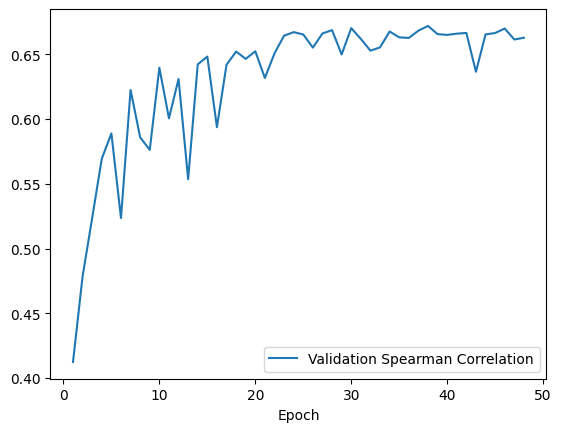

In [7]:
# Plot CNN training curves
epochs_cnn = list(range(1, len(cnn_history['train_losses']) + 1))
plot(epochs_cnn, {
    'Train Loss': cnn_history['train_losses'],
    'Validation Loss': cnn_history['val_losses']
}, filename='cnn_loss_curves.pdf')

plot(epochs_cnn, {
    'Validation Spearman Correlation': cnn_history['val_correlations']
}, filename='cnn_correlation.pdf')

# Plot LSTM training curves
epochs_lstm = list(range(1, len(lstm_history['train_losses']) + 1))
plot(epochs_lstm, {
    'Train Loss': lstm_history['train_losses'],
    'Validation Loss': lstm_history['val_losses']
}, filename='lstm_loss_curves.pdf')

plot(epochs_lstm, {
    'Validation Spearman Correlation': lstm_history['val_correlations']
}, filename='lstm_correlation.pdf')

print("Training curves saved!")


## Evaluate on Test Set

**Important**: Only evaluate on test set once, after hyperparameter tuning is complete!


In [8]:
def evaluate_test(model, test_loader, device, model_name):
    """Evaluate model on test set."""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_masks = []
    num_batches = 0
    
    with torch.no_grad():
        for batch in test_loader:
            x, y, mask = batch
            x = x.to(device)
            y = y.to(device)
            mask = mask.to(device)
            
            predictions = model(x)
            loss = masked_mse_loss(predictions, y, mask)
            total_loss += loss.item()
            
            all_predictions.append(predictions)
            all_targets.append(y)
            all_masks.append(mask)
            num_batches += 1
    
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)
    all_masks = torch.cat(all_masks, dim=0)
    
    test_loss = total_loss / num_batches if num_batches > 0 else 0.0
    spearman_corr = masked_spearman_correlation(all_predictions, all_targets, all_masks)
    
    # Additional metrics
    pred_np = all_predictions.squeeze().cpu().numpy()
    target_np = all_targets.squeeze().cpu().numpy()
    mask_np = all_masks.squeeze().cpu().numpy().astype(bool)
    
    valid_preds = pred_np[mask_np]
    valid_targets = target_np[mask_np]
    
    if len(valid_preds) > 1:
        pearson_corr = np.corrcoef(valid_preds, valid_targets)[0, 1]
        mae = np.mean(np.abs(valid_preds - valid_targets))
        rmse = np.sqrt(np.mean((valid_preds - valid_targets) ** 2))
    else:
        pearson_corr = 0.0
        mae = 0.0
        rmse = 0.0
    
    print(f"\n{model_name} Test Set Results:")
    print(f"  Spearman Correlation: {spearman_corr.item():.4f}")
    print(f"  Pearson Correlation:  {pearson_corr:.4f}")
    print(f"  Test Loss (MSE):      {test_loss:.4f}")
    print(f"  MAE:                  {mae:.4f}")
    print(f"  RMSE:                 {rmse:.4f}")
    
    return {
        'spearman_correlation': float(spearman_corr.item()),
        'pearson_correlation': float(pearson_corr),
        'test_loss': float(test_loss),
        'mae': float(mae),
        'rmse': float(rmse)
    }

# Evaluate CNN
cnn_test_results = evaluate_test(cnn_model, test_loader, device, 'CNN')

# Evaluate LSTM
lstm_test_results = evaluate_test(lstm_model, test_loader, device, 'LSTM')



CNN Test Set Results:
  Spearman Correlation: 0.5820
  Pearson Correlation:  0.7356
  Test Loss (MSE):      0.6588
  MAE:                  0.5242
  RMSE:                 0.8115

LSTM Test Set Results:
  Spearman Correlation: 0.6574
  Pearson Correlation:  0.8041
  Test Loss (MSE):      0.3735
  MAE:                  0.4200
  RMSE:                 0.6110


## Model Comparison


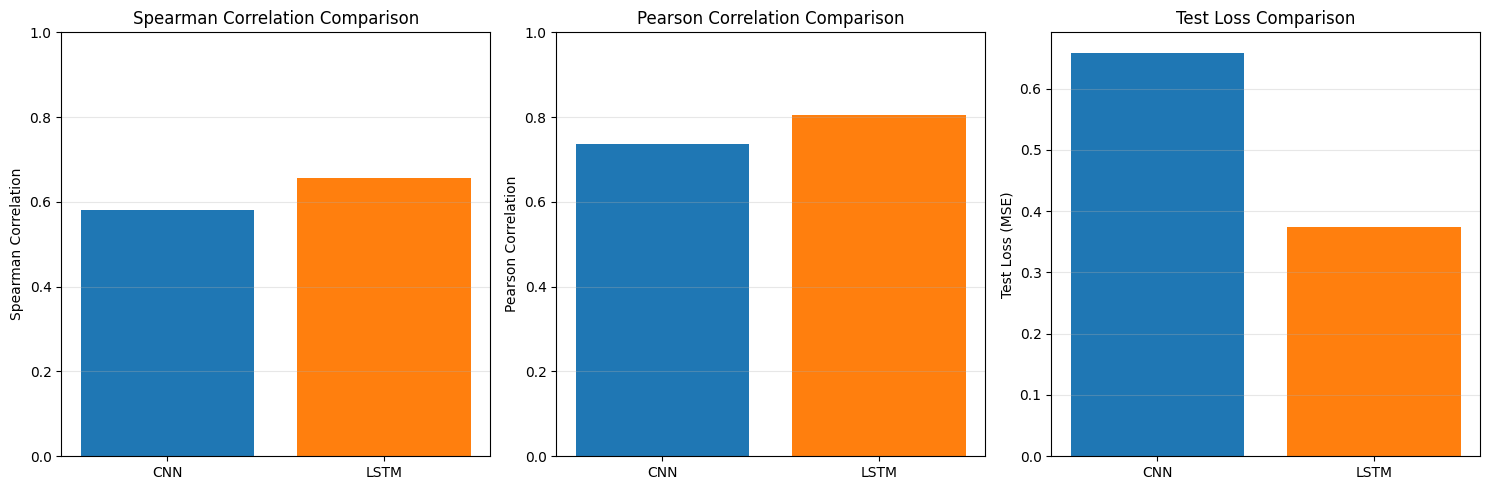


Model Comparison Summary:
CNN - Spearman: 0.5820, Pearson: 0.7356, Loss: 0.6588
LSTM - Spearman: 0.6574, Pearson: 0.8041, Loss: 0.3735


In [9]:
# Comparison plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

model_names = ['CNN', 'LSTM']
spearman_corrs = [cnn_test_results['spearman_correlation'], lstm_test_results['spearman_correlation']]
pearson_corrs = [cnn_test_results['pearson_correlation'], lstm_test_results['pearson_correlation']]
test_losses = [cnn_test_results['test_loss'], lstm_test_results['test_loss']]

axes[0].bar(model_names, spearman_corrs, color=['#1f77b4', '#ff7f0e'])
axes[0].set_ylabel('Spearman Correlation')
axes[0].set_title('Spearman Correlation Comparison')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(model_names, pearson_corrs, color=['#1f77b4', '#ff7f0e'])
axes[1].set_ylabel('Pearson Correlation')
axes[1].set_title('Pearson Correlation Comparison')
axes[1].set_ylim([0, 1])
axes[1].grid(True, alpha=0.3, axis='y')

axes[2].bar(model_names, test_losses, color=['#1f77b4', '#ff7f0e'])
axes[2].set_ylabel('Test Loss (MSE)')
axes[2].set_title('Test Loss Comparison')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('model_comparison.pdf', bbox_inches='tight')
plt.show()

print("\nModel Comparison Summary:")
print("=" * 80)
print(f"CNN - Spearman: {cnn_test_results['spearman_correlation']:.4f}, "
      f"Pearson: {cnn_test_results['pearson_correlation']:.4f}, "
      f"Loss: {cnn_test_results['test_loss']:.4f}")
print(f"LSTM - Spearman: {lstm_test_results['spearman_correlation']:.4f}, "
      f"Pearson: {lstm_test_results['pearson_correlation']:.4f}, "
      f"Loss: {lstm_test_results['test_loss']:.4f}")


## Save Results


In [10]:
# Save results to JSON
results = {
    'cnn': {
        'config': CNN_CONFIG,
        'training_history': cnn_history,
        'test_results': cnn_test_results
    },
    'lstm': {
        'config': LSTM_CONFIG,
        'training_history': lstm_history,
        'test_results': lstm_test_results
    }
}

with open('results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to results.json")


Results saved to results.json
